# **ETPoF** Homework 3
Annemarie Linnenbank & Tommie Verouden

*22 March 2024*

In [1]:
# Ensure the module is automatically reloaded when rerunning the import command.
%load_ext autoreload
%autoreload 2

In [31]:
import etpof
import matplotlib.pyplot as plt

## Particle Tracking (25 points)
### 1) **Calibration** (3 pts)

We start by illustrating the calibration of camera a). Below it, we outline 
the steps taken to obtain these results. The functions used can be found in `functions1.py`, which is part of the `etpof` module, added as an appendix below.

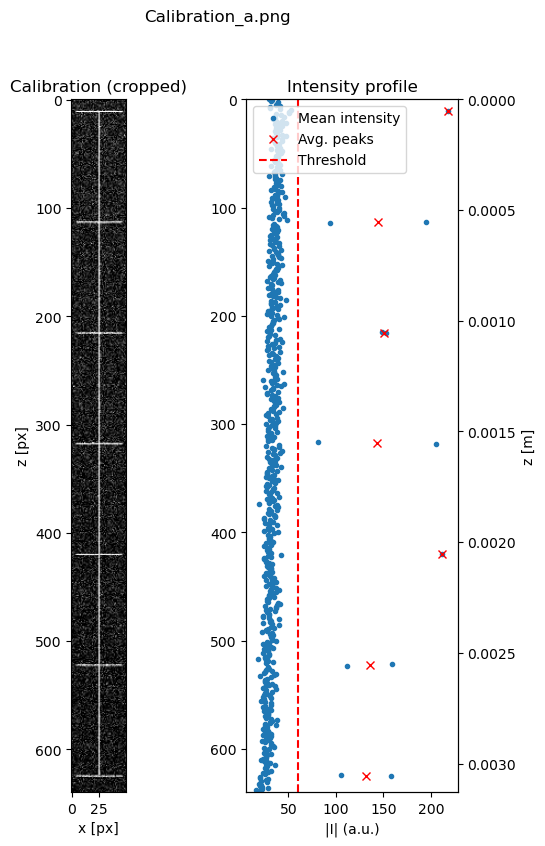

In [3]:
directory = 'PTV'
roi_calib = [200, 250, 30, 670]
calib_dist = 0.5 # [m]
threshold = 60

_, _, _, = etpof.calibrate_cameras(directory, roi_calib, calib_dist, threshold,
                                   peak_method='weighted_avg',
                                   file_prefix='Calibration_', 
                                   plot=[True, False], verbose=False,
                                   precision=7, units='m')


For each camera, we go through the following calibration steps:
1. We import the (grayscale) calibration image and manually inspect it to determine a suitable region of interest (ROI), containing the calibration pattern, but not the scale numbers and as little background noise as possible.
2. We assume that the background noise is the same throughout the image, and 
that the horizontal lines are, in fact, horizontal. _On closer inspection, the vertical line connecting the calibration lines has no angle: it follows a single pixel column._
3. These two assumptions allow us to average the pixel values in the ROI in the horizontal direction to obtain a 1D "intensity profile" of the calibration image.
4. We then calculate the subpixel position of the peaks in the intensity 
profile by taking the average $z$ coordinate of all values around each peak that are larger than a set threshold. In the plot, these are the points to the right of the red dashed line. In calculating the average, we weigh each row by its intensity value. _Note that we could have also used fitted a Gaussian or 
another function to determine the exact peak, but this method already 
resulted in such a small error, and it did not seem to make much sense to fit a function to the 1 or 2 data points making up each peak._
5. Like in the previous homework assignment, we calculate all possible 
distances between the peaks (i.e., from the top line to the second one, one 
to three, one to four, etc.) and get a resolution value corresponding to each line-line combination by dividing between the distance in "real space". This distance is given by the calibration distance divided by the number of lines separating the two peaks.
6. Finally, we average the resolution values, weighted by the distance in 
real space, to obtain the final resolution value. This way, the longer distances, which contain a smaller error, weigh more heavily. The (weighted) standard deviation of the set of resolution values then gives us a measure of the error in the calibration.

Besides the resolution value, we also obtain an offset value, given by the average difference in position of the seven lines between the images of camera b) and a). This offset will later be used to align the images of the cameras.

In [4]:
res_avg, res_std, offset\
    = etpof.calibrate_cameras(directory, roi_calib, calib_dist, threshold)

print(f'\nResolution difference across the image: '
      f'{(abs(res_std[1] - res_std[0]) * 860 * 1000):.2f} mm.')

==> Calibration_a.png:
The average resolution is 0.0048892 m/px,
with a standard deviation of 0.0000018 m/px (0.038 %).
==> Calibration_b.png:
The average resolution is 0.0048895 m/px,
with a standard deviation of 0.0000017 m/px (0.034 %).
The offfset is -0.0000494 m.

Resolution difference across the image: 0.13 mm.


The results of the calibration are shown above, and are very similar for the 
two cameras at $4.89$ $\rm{mm/px}$. The standard error is also very similar, at $2$ $\rm{\mu m/px}$. The difference in resolution between the two cameras can only account for a total error of about $0.13$ $\rm{mm}$ across the entire height of the images of about 0.13 mm.
 
In the next parts, we will use the resolution values corresponding to the camera with which the image was taken, and apply the offset (about to the coordinates in camera b). 

### 2) **Particle detection** (3 pts)

For detecting the particles, we have written the following algorithm. To be 
subpixel-accurate, we have tried to perform the least possible number of destructive operations. The functions used can be found in `functions2.py`, which is also part of the `etpof` module in the appendix. The steps below are performed on each image separately.

#### 1. Pre-processing
- We start by reading the image file and pre-processing the image. The goal 
here is to remove the (noisy) background while keeping the greyscale values of the particles intact.
- We apply a bilateral filter to the image to remove noise while keeping the 
edges sharp. This filter works by replacing the intensity of each pixel with a (Gaussian) weighted average of the intensities of nearby pixels. However, for each nearby pixel, the difference in (color) intensity is also taken into account using another (Gaussian) kernel. Therefore, we supply the filter with two kernel sizes. These values are determined empirically, and we have found that the filter works well with a larger colour kernel size than the spatial kernel size.
- A second bilateral filter with smaller kernel sizes is applied to remove finer details in the image.
- Remaining dim pixels and rough edges around the particles are removed by applying a threshold operation that sets pixels below a certain intensity to zero.
- We further clean up the background by using a hit-or-miss filter to remove horizontal or vertical stripes that do not have any (diagonal) neighbours. This works well to prevent false positives later on.

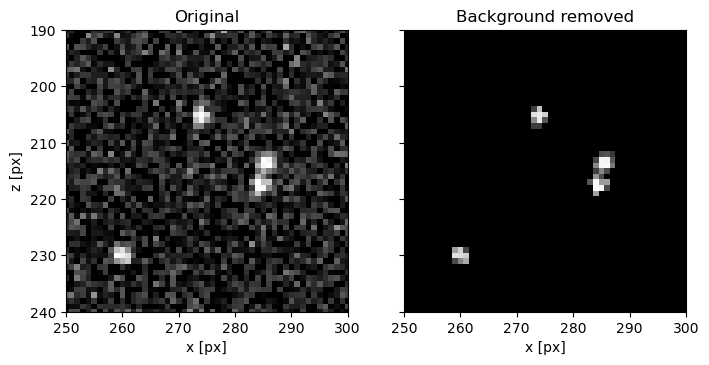

In [51]:
# Remove background from an example image
test_image = etpof.read_image('PTV/a1.png')
processed_image = etpof.remove_background(test_image)

# Plot a part of the original and processed image
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(test_image, cmap='gray')
ax[0].set_xlim([250, 300])
ax[0].set_ylim([240, 190])
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('z [px]')
ax[0].set_title('Original')
ax[1].imshow(processed_image, cmap='gray')
ax[1].set_xlim([250, 300])
ax[1].set_ylim([240, 190])
ax[1].set_xlabel('x [px]')
ax[1].set_yticklabels([])
ax[1].set_title('Background removed')
plt.show()


As can be seen, we are left with just the particles, and their details are still intact (albeit slightly dimmer).

Processing images: 100%|██████████| 200/200 [00:12<00:00, 16.12it/s]


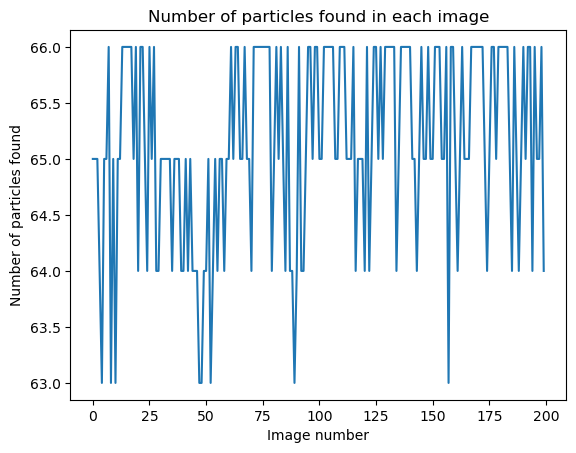

Found between 63 and 66 particles in each image, with a median of 65.0.


In [32]:
# For camera a
coords, intensities, coords_err, intensities_err, particles_found \
    = etpof.analyze_camera('PTV', 'a', res_avg[0], offset[0],
                           min_contour_area=1, min_intensity=200, 
                           neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True)

In [ ]:
# For camera b
coords, intensities, coords_err, intensities_err, particles_found \
    = etpof.analyze_camera('PTV', 'b', res_avg[1], offset[1],
                           min_cnt_area=1, min_intensity=200, neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, plot=True)

## Appendix

Todo: add the etpof module here!